# Twitter Covid-19 Analysis
Tweets are collected with Twitter API and saved on the project GitHub repository.

In [ ]:
# pip install -q tfds-nightly

     |████████████████████████████████| 3.6MB 2.8MB/s 


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os

import pandas as pd
import numpy as np
from glob import glob
import re
import nltk

from sklearn.decomposition import PCA
from scipy.linalg import norm
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set(style='ticks')
%matplotlib inline

In [ ]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Load

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/jaeh-lee/twitter_covid19/master/tweets_final.csv')

In [5]:
# filter english tweets and columns to use
df_eng = df[df['language'] == 'en']
df_train = df_eng[['id_str', 'text', 'sentiment_compound']]
df_train = df_train[df_train['sentiment_compound']!=0]
df_train = df_train.rename(columns={'id_str': 'id', 'sentiment_compound': 'label'})
df_train = df_train.reset_index(drop=True)
df_train

,id,text,label
0,1316348942414745602,@Mike_Pence Now...we wait and see how many of ...,-1.0
1,1316351906479038464,#IRSRailWebinars: smart motors’ platform scree...,1.0
2,1316356094965493760,A Coronavirus Vaccine Could Kill Half A Millio...,-1.0
3,1316363607924502528,"Perspective | As a doctor, I must act when cor...",-1.0
4,1316365169669349377,COVID-19 outbreak – 116 deaths and 6526 new ca...,-1.0
...,...,...,...
26289,1326313684851896321,RT @BernieSanders: When we talk about the dest...,-1.0
26290,1326313685065883649,If you're in Minneapolis consider these free C...,1.0
26291,1326313685590142982,"RT @PVAMU: PVAMU receives a $10,000,000 gift f...",1.0
26292,1326313686089207813,St. Clair County reports daily record for COVI...,1.0


Text(0, 0.5, 'Number of tweets')

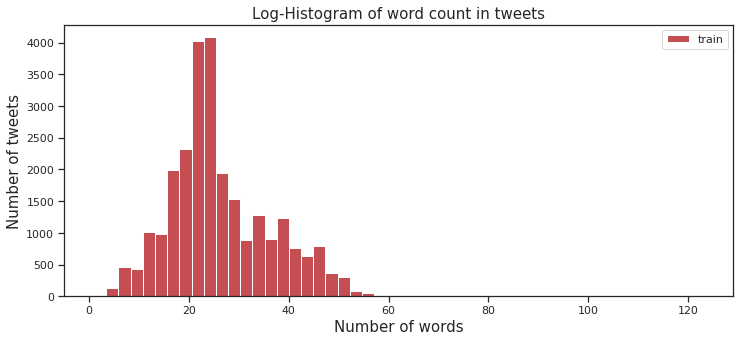

In [6]:
# distribution of word counts in tweets
train_word_counts = df_train['text'].astype(str).apply(lambda x:len(x.split(' ')))

plt.figure(figsize=(12, 5))
plt.hist(train_word_counts, bins=50, facecolor='r',label='train')
plt.title('Log-Histogram of word count in tweets', fontsize=15)
# plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Number of tweets', fontsize=15)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


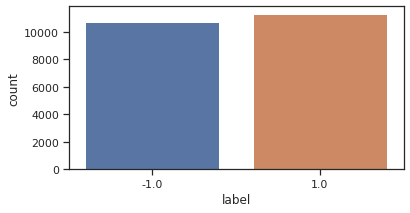

In [ ]:
# distribution of sentiments (positive vs. negative)
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(df_train['label'])

In [ ]:
print("Positive tweets: {}".format(df_train['label'].value_counts()[1]))
print("Negative tweets: {}".format(df_train['label'].value_counts()[-1]))

Positive tweets: 11316
Negative tweets: 10748


## Tokenize

In [ ]:
from nltk import word_tokenize 

In [ ]:
stemmer = SnowballStemmer("english")

In [ ]:
from nltk.corpus import stopwords # Import the stop word list
from nltk.stem.snowball import SnowballStemmer

def preprocessing(tweet, stops = []):

    tweet_text = re.sub("[^\w\s]", "", tweet) 
    
    word_tweet = word_tokenize(tweet_text.lower())
    word_tweet = [w for w in word_tweet if not w in stops]
    word_tweet = ([stemmer.stem(w) for w in word_tweet])
   
    return word_tweet

In [ ]:
from tqdm import tqdm

clean_train_tweet = []
stops = set(stopwords.words("english"))  

for tweet in tqdm(df_train['text']):
    if type(tweet) == str:
        clean_train_tweet.append(preprocessing(tweet, stops=stops))
    else:
        clean_train_tweet.append([])

100%|██████████| 26294/26294 [00:15<00:00, 1698.65it/s]


In [ ]:
import numpy as np
import pandas as pd
import re
import json
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_tweet)
train_sequences = tokenizer.texts_to_sequences(clean_train_tweet)
train_labels = np.array(df_train['label'])

In [ ]:
MAX_SEQUENCE_LENGTH = 8
train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [ ]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

input_data = train_inputs
label_data = train_labels
word_vocab = tokenizer.word_index

TEST_SPLIT = 0.1
RNG_SEED = 13371447
VOCAB_SIZE = len(word_vocab) + 1
EMB_SIZE = 128
BATCH_SIZE = 16
NUM_EPOCHS = 1

In [ ]:
input_train, input_eval, label_train, label_eval = train_test_split(input_data, label_data, test_size=TEST_SPLIT, random_state=RNG_SEED)

In [ ]:
def mapping_fn(X, Y):
    input, label = {'x': X}, Y
    return input, label

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((input_train, label_train))
    dataset = dataset.shuffle(buffer_size=len(input_train))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(mapping_fn)
    dataset = dataset.repeat(count=NUM_EPOCHS)
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((input_eval, label_eval))
    dataset = dataset.batch(128)
    dataset = dataset.map(mapping_fn)
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((input_train, label_train))
train_dataset = train_dataset.shuffle(buffer_size=len(input_train))
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.map(mapping_fn)
train_dataset = train_dataset.repeat(count=NUM_EPOCHS)

In [ ]:
valid_dataset = tf.data.Dataset.from_tensor_slices((input_eval, label_eval))
valid_dataset = valid_dataset.batch(128)
valid_dataset = valid_dataset.map(mapping_fn)

## Create t-SNE plots

In [ ]:
from gensim.models import word2vec
from sklearn.manifold import TSNE

In [ ]:
def tsne_plot(model):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 16)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


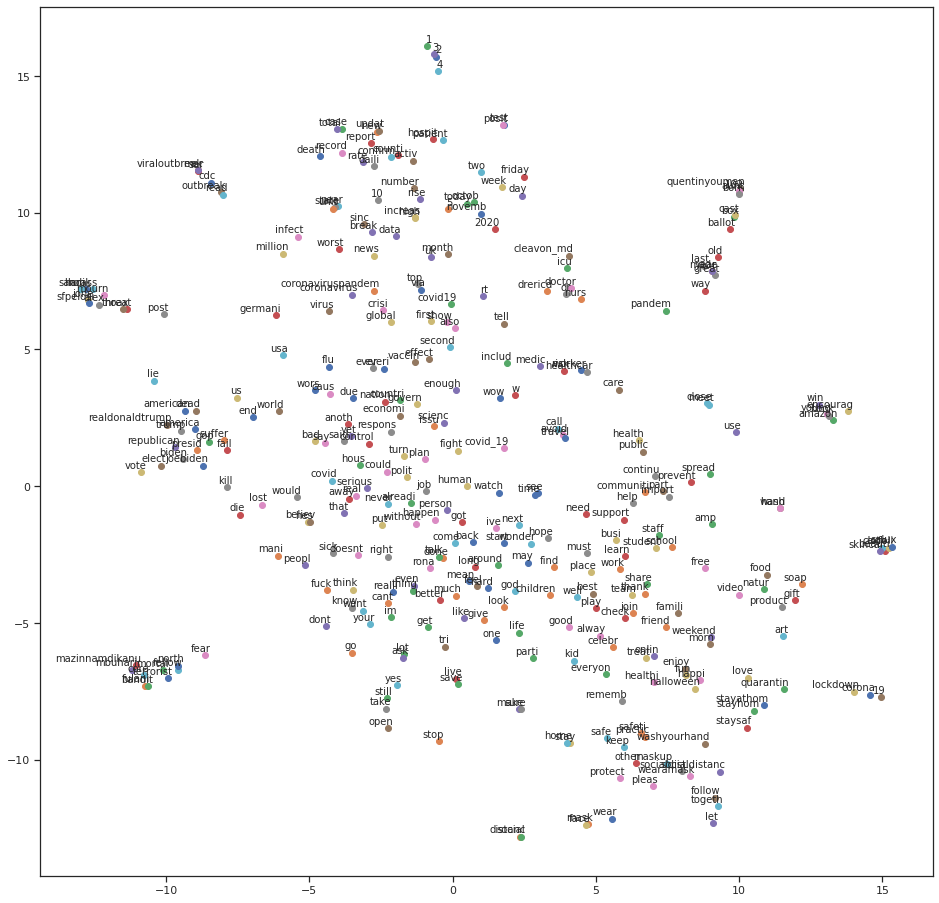

In [ ]:
model = word2vec.Word2Vec(clean_train_tweet, size=100, window=20, min_count=200, workers=4)
tsne_plot(model)

In [ ]:
model.wv.save_word2vec_format('eng_w2v')

In [ ]:
# export tensor and metadata for visualization with TensorBoard
!python -m gensim.scripts.word2vec2tensor --input eng_w2v --output eng_w2v

2020-11-12 03:17:40,905 - word2vec2tensor - INFO - running /usr/local/lib/python3.6/dist-packages/gensim/scripts/word2vec2tensor.py --input eng_w2v --output eng_w2v
2020-11-12 03:17:40,905 - utils_any2vec - INFO - loading projection weights from eng_w2v
2020-11-12 03:17:40,979 - utils_any2vec - INFO - loaded (726, 100) matrix from eng_w2v
2020-11-12 03:17:41,041 - word2vec2tensor - INFO - 2D tensor file saved to eng_w2v_tensor.tsv
2020-11-12 03:17:41,042 - word2vec2tensor - INFO - Tensor metadata file saved to eng_w2v_metadata.tsv
2020-11-12 03:17:41,042 - word2vec2tensor - INFO - finished running word2vec2tensor.py


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


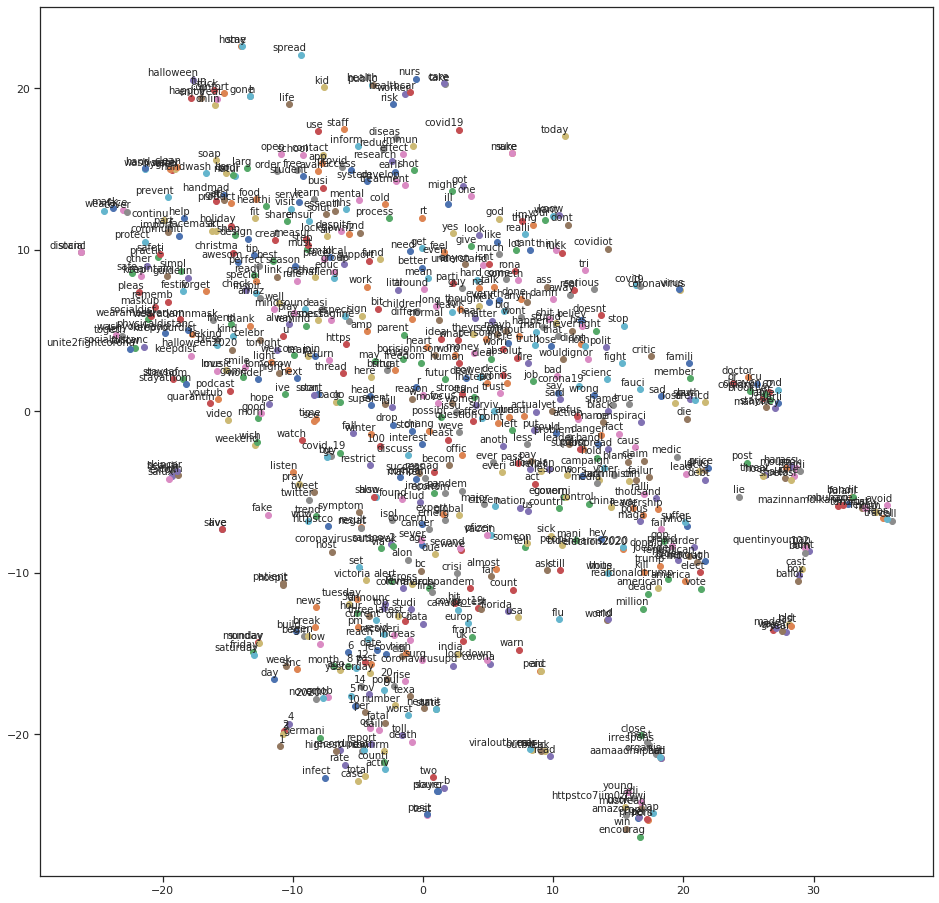

In [ ]:
model = word2vec.Word2Vec(clean_train_tweet, size=100, window=20, min_count=100, workers=4)
tsne_plot(model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


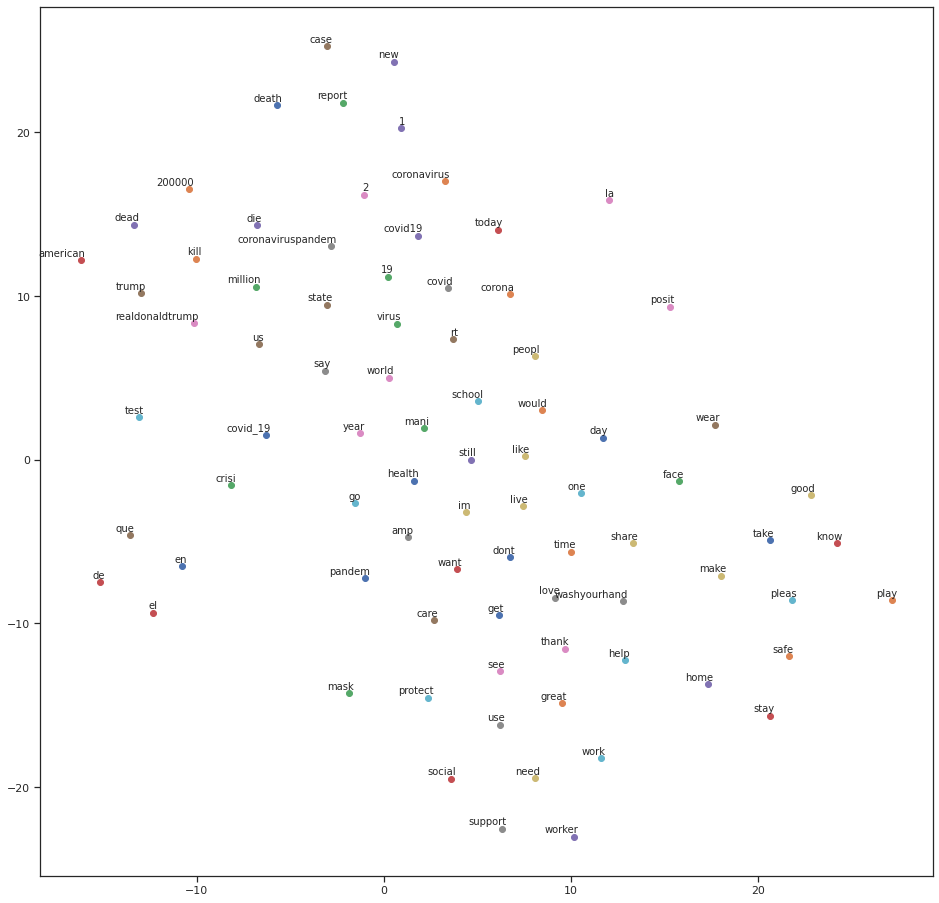

In [ ]:
model = word2vec.Word2Vec(clean_train_tweet, size=100, window=20, min_count=500, workers=4)
tsne_plot(model)